In [ ]:
# ==========================================
# Cell 1: Setup and Installation
# ==========================================

# Install required packages
!pip install tensorflow scikit-learn pandas numpy

# Import libraries
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, GlobalAveragePooling1D, Dense,
    MultiHeadAttention, LayerNormalization, add, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

print(f" TensorFlow version: {tf.__version__}")

 TensorFlow version: 2.18.0


In [ ]:
# ==========================================
# Cell 2: Mount Drive and Setup Paths
# ==========================================

from google.colab import drive
drive.mount('/content/drive')

# Project configuration
PROJECT_ROOT = '/content/drive/MyDrive/protein_classification'
DATA_DIR = f'{PROJECT_ROOT}/data'
MODELS_DIR = f'{PROJECT_ROOT}/models'
RESULTS_DIR = f'{PROJECT_ROOT}/results'
OUTPUTS_DIR = f'{PROJECT_ROOT}/outputs'

# Ensure output directories exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(OUTPUTS_DIR, exist_ok=True)


# Change to project directory
os.chdir(PROJECT_ROOT)
print(f"Working directory: {os.getcwd()}")

Mounted at /content/drive
Working directory: /content/drive/MyDrive/protein_classification


In [ ]:
# ==========================================
# Cell 3: Model Configuration and Hyperparameters
# ==========================================

MODEL_NAME = 'CustomTransformer'

transformer_config = {
    'max_length': 1024,
    'embed_dim': 128,
    'num_heads': 8,
    'learning_rate': 5e-5,
    'batch_size': 16,
    'epochs': 15,
    'dropout_rate_attn': 0.1,
    'dropout_rate_ffn': 0.1,
    'dropout_rate_cls': 0.2,
    'early_stopping_patience': 5,
    'reduce_lr_patience': 2,
}

print("Transformer Model Configuration:")
for key, value in transformer_config.items():
    print(f"  {key}: {value}")


Transformer Model Configuration:
  max_length: 1024
  embed_dim: 128
  num_heads: 8
  learning_rate: 5e-05
  batch_size: 16
  epochs: 15
  dropout_rate_attn: 0.1
  dropout_rate_ffn: 0.1
  dropout_rate_cls: 0.2
  early_stopping_patience: 5
  reduce_lr_patience: 2


In [ ]:
# ==========================================
# Cell 4: Load Data Splits
# ==========================================

def load_data_splits():
    """Load the prepared data splits"""
    splits_path = f'{RESULTS_DIR}/data_splits.pkl'

    if not os.path.exists(splits_path):
        print(" Data splits not found!")
        print(" Please run 01_data_preparation.ipynb first.")
        return None

    try:
        with open(splits_path, 'rb') as f:
            data_splits = pickle.load(f)
        print(" Data splits loaded successfully!")

        # Show data summary
        for split_name, split_data in data_splits.items():
            if isinstance(split_data, list):
                print(f"   {split_name}: {len(split_data):,} samples")

        return data_splits
    except Exception as e:
        print(f" Error loading data: {e}")
        return None

# Load data
data_splits = load_data_splits()

 Data splits loaded successfully!
   train_seq: 48,000 samples
   train_labels: 48,000 samples
   val_seq: 16,000 samples
   val_labels: 16,000 samples
   test_seq: 16,000 samples
   test_labels: 16,000 samples


In [ ]:
# ==========================================
# Cell 5: Data Preparation Functions
# ==========================================

def prepare_sequences_for_keras(sequences, max_length):
    """Prepare protein sequences for Keras models"""

    char_vals = {
        "M":1, "N":2, "S":3, "K":4, "I":5, "F":6, "A":7, "V":8, "L":9, "G":10,
        "R":11, "C":12, "D":13, "Q":14, "Y":15, "P":16, "T":17, "E":18,
        "H":19, "W":20, "X":21, "U":22, "Z":23, "B":24, "O":25, "-":26
    }

    max_tokens_count = len(char_vals) + 1

    def encode_sequence(sequence):
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence = sequence + "-" * (max_length - len(sequence))

        return [char_vals.get(char, 26) for char in sequence]

    print(f"Encoding {len(sequences):,} sequences with max_length={max_length}...")
    encoded = np.array([encode_sequence(seq) for seq in sequences])
    print(f"Encoded shape: {encoded.shape}")

    return encoded, max_tokens_count

# Prepare data for training
if data_splits is not None:
    print("Preparing data for Transformer...")

    X_train, max_tokens_train = prepare_sequences_for_keras(data_splits['train_seq'], transformer_config['max_length'])
    X_val, max_tokens_val = prepare_sequences_for_keras(data_splits['val_seq'], transformer_config['max_length'])
    X_test, max_tokens_test = prepare_sequences_for_keras(data_splits['test_seq'], transformer_config['max_length'])

    MAX_TOKENS = max(max_tokens_train, max_tokens_val, max_tokens_test)

    y_train = np.array(data_splits['train_labels'])
    y_val = np.array(data_splits['val_labels'])
    y_test = np.array(data_splits['test_labels'])

    print(f"Data preparation complete!")
    print(f"  Training: {X_train.shape} -> {y_train.shape}")
    print(f"  Validation: {X_val.shape} -> {y_val.shape}")
    print(f"  Test: {X_test.shape} -> {y_test.shape}")
    print(f"  Max tokens (vocabulary size): {MAX_TOKENS}")

Preparing data for Transformer...
Encoding 48,000 sequences with max_length=1024...
Encoded shape: (48000, 1024)
Encoding 16,000 sequences with max_length=1024...
Encoded shape: (16000, 1024)
Encoding 16,000 sequences with max_length=1024...
Encoded shape: (16000, 1024)
Data preparation complete!
  Training: (48000, 1024) -> (48000,)
  Validation: (16000, 1024) -> (16000,)
  Test: (16000, 1024) -> (16000,)
  Max tokens (vocabulary size): 27


In [ ]:
# ==========================================
# Cell 6: Build Transformer Model
# ==========================================

def build_transformer_model(input_shape, max_tokens, embed_dim, num_heads,
                            dropout_rate_attn, dropout_rate_ffn, dropout_rate_cls):
    """Build Transformer model with attention mechanism"""

    print(f"Building Transformer model...")
    print(f"  Input shape: {input_shape}")
    print(f"  Max tokens: {max_tokens}")
    print(f"  Embedding dim: {embed_dim}")
    print(f"  Attention heads: {num_heads}")

    # Input layer
    inputs = Input(shape=input_shape, name='sequence_input')

    # Embedding layer
    embed = Embedding(
        input_dim=max_tokens,
        output_dim=embed_dim,
        name='amino_acid_embedding'
    )(inputs)

    # Multi-head attention block
    attention_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim,
        dropout=dropout_rate_attn,
        name='multi_head_attention'
    )(embed, embed)

    x = add([attention_output, embed], name='add_1')
    x = LayerNormalization(name='norm_1')(x)

    # Feed-forward block
    residual = x
    x = Dense(embed_dim * 2, activation="relu", name='feed_forward_1')(x)
    x = Dropout(dropout_rate_ffn, name='dropout_1')(x)
    x = Dense(embed_dim, name='feed_forward_2')(x)

    # Add & Norm 2
    x = add([x, residual], name='add_2')
    x = LayerNormalization(name='norm_2')(x)

    # Classification head
    x = GlobalAveragePooling1D(name='global_pooling')(x)
    x = Dense(64, activation="relu", name='dense_1')(x)
    x = Dropout(dropout_rate_cls, name='dropout_2')(x)
    outputs = Dense(1, activation="sigmoid", name='classification_output')(x)

    # Create model
    model = Model(inputs, outputs, name=MODEL_NAME)
    return model

# Build the model using configured parameters
model = build_transformer_model(
    input_shape=(transformer_config['max_length'],),
    max_tokens=MAX_TOKENS,
    embed_dim=transformer_config['embed_dim'],
    num_heads=transformer_config['num_heads'],
    dropout_rate_attn=transformer_config['dropout_rate_attn'],
    dropout_rate_ffn=transformer_config['dropout_rate_ffn'],
    dropout_rate_cls=transformer_config['dropout_rate_cls']
)

Building Transformer model...
  Input shape: (1024,)
  Max tokens: 27
  Embedding dim: 128
  Attention heads: 8


In [ ]:

# ==========================================
# Cell 7: Model Compilation and Summary
# ==========================================

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=transformer_config['learning_rate']), # 使用配置中的学习率
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(name='precision'), Recall(name='recall')]
)

print("Model Summary:")
model.summary()

# Count parameters
total_params = model.count_params()
print(f"Total parameters: {total_params:,}")

Model Summary:


Model: "CustomTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ amino_acid_embeddi… │ (None, 1024, 128) │      3,456 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1024, 128) │    527,488 │ amino_acid_embed… │
│ (MultiHeadAttentio… │                   │            │ amino_acid_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1024, 128) │          0 │ multi_head_atten… │
│                     │                   │            │ amino_acid_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_1              │ (None, 1024, 128) │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_1      │ (None, 1024, 256) │     33,024 │ norm_1[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024, 256) │          0 │ feed_forward_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_2      │ (None, 1024, 128) │     32,896 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1024, 128) │          0 │ feed_forward_2[0… │
│                     │                   │            │ norm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_2              │ (None, 1024, 128) │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_pooling      │ (None, 128)       │          0 │ norm_2[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ global_pooling[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 1)         │         65 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 605,697 (2.31 MB)

 Trainable params: 605,697 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Total parameters: 605,697


In [ ]:

# ==========================================
# Cell 8: Setup Training Callbacks
# ==========================================

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=transformer_config['early_stopping_patience'],
        restore_best_weights=True,
        monitor='val_accuracy',
        verbose=1,
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=transformer_config['reduce_lr_patience'],
        min_lr=1e-6,
        verbose=1,
        monitor='val_accuracy',
        mode='max'
    ),
    tf.keras.callbacks.ModelCheckpoint(
        f'{MODELS_DIR}/{MODEL_NAME}_best.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1,
        mode='max'
    )
]

print("Callbacks configured:")
for callback in callbacks:
    print(f"  - {callback.__class__.__name__}")

Callbacks configured:
  - EarlyStopping
  - ReduceLROnPlateau
  - ModelCheckpoint


In [ ]:


# ==========================================
# Cell 9: Train the Model
# ==========================================

print("Starting Transformer training...")
print("=" * 60)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=transformer_config['epochs'],
    batch_size=transformer_config['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Starting Transformer training...
Epoch 1/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8072 - loss: 0.4188 - precision: 0.8507 - recall: 0.7465
Epoch 1: val_accuracy improved from -inf to 0.85938, saving model to /content/drive/MyDrive/protein_classification/models/CustomTransformer_best.keras
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 379s 122ms/step - accuracy: 0.8072 - loss: 0.4188 - precision: 0.8507 - recall: 0.7465 - val_accuracy: 0.8594 - val_loss: 0.3275 - val_precision: 0.9200 - val_recall: 0.7872 - learning_rate: 5.0000e-05
Epoch 2/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8574 - loss: 0.3374 - precision: 0.9148 - recall: 0.7862
Epoch 2: val_accuracy improved from 0.85938 to 0.86119, saving model to /content/drive/MyDrive/protein_classification/models/CustomTransformer_best.keras
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 371s 122ms/step - accuracy: 0.8574 - loss: 0.3374 - precision: 0.9148 - recall: 0.7862 - val_accuracy: 0.8612 - val_loss: 0.3247 - val_precision

In [ ]:
# ==========================================
# Cell 10: Load Best Model and Evaluate
# ==========================================

# Load the best model (saved by ModelCheckpoint)
print("Loading best model for final evaluation...")
try:
    model = tf.keras.models.load_model(f'{MODELS_DIR}/{MODEL_NAME}_best.keras')
except Exception as e:
    print(f"Error loading best model: {e}")
    print("Proceeding with the last trained model (might not be the best).")
    # If loading best model fails, continue with the current model state

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

# Calculate detailed metrics
print("Calculating detailed metrics...")
y_pred = model.predict(X_test, verbose=0)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

detailed_results = {
    'eval_accuracy': accuracy_score(y_test, y_pred_binary),
    'eval_precision': precision_score(y_test, y_pred_binary),
    'eval_recall': recall_score(y_test, y_pred_binary),
    'eval_f1': f1_score(y_test, y_pred_binary)
}

Loading best model for final evaluation...
Evaluating on test set...
Calculating detailed metrics...


In [ ]:
# ==========================================
# Cell 11: Save Model and Results
# ==========================================

model_save_path = f'{MODELS_DIR}/{MODEL_NAME}_final.keras'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

# Print final results
print("=" * 60)
print(f"{MODEL_NAME.upper()} MODEL RESULTS")
print("=" * 60)
print(f"Accuracy:  {detailed_results['eval_accuracy']:.4f}")
print(f"Precision: {detailed_results['eval_precision']:.4f}")
print(f"Recall:    {detailed_results['eval_recall']:.4f}")
print(f"F1-Score:  {detailed_results['eval_f1']:.4f}")
print("=" * 60)

results = {
    'model_name': MODEL_NAME,
    'model_checkpoint_path': model_save_path,
    'training_summary': {
        'total_epochs_run': len(history.history['loss']),
        'final_accuracy': detailed_results['eval_accuracy'],
        'final_f1': detailed_results['eval_f1'],
        'target_achieved': detailed_results['eval_accuracy'] >= 0.99
    },
    'stage_results': {
        'final': detailed_results
    },
    'training_history': history.history,
    'model_config': transformer_config,
    'test_data_shape': X_test.shape
}

# Save results
results_path = f'{RESULTS_DIR}/{MODEL_NAME}_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to: {results_path}")

summary_path = f'{RESULTS_DIR}/{MODEL_NAME}_training_summary.txt'
with open(summary_path, 'w') as f:
    f.write(f"{MODEL_NAME} Training Summary\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Model: {MODEL_NAME}\n")
    f.write(f"Final Accuracy: {detailed_results['eval_accuracy']:.4f}\n")
    f.write(f"Final F1-Score: {detailed_results['eval_f1']:.4f}\n")
    f.write(f"Target (99%) Achieved: {'Yes' if detailed_results['eval_accuracy'] >= 0.99 else 'No'}\n")

print(f" Summary saved to: {summary_path}")


Model saved to: /content/drive/MyDrive/protein_classification/models/CustomTransformer_final.keras
CUSTOMTRANSFORMER MODEL RESULTS
Accuracy:  0.8859
Precision: 0.9478
Recall:    0.8167
F1-Score:  0.8774
Results saved to: /content/drive/MyDrive/protein_classification/results/CustomTransformer_results.pkl
 Summary saved to: /content/drive/MyDrive/protein_classification/results/CustomTransformer_training_summary.txt


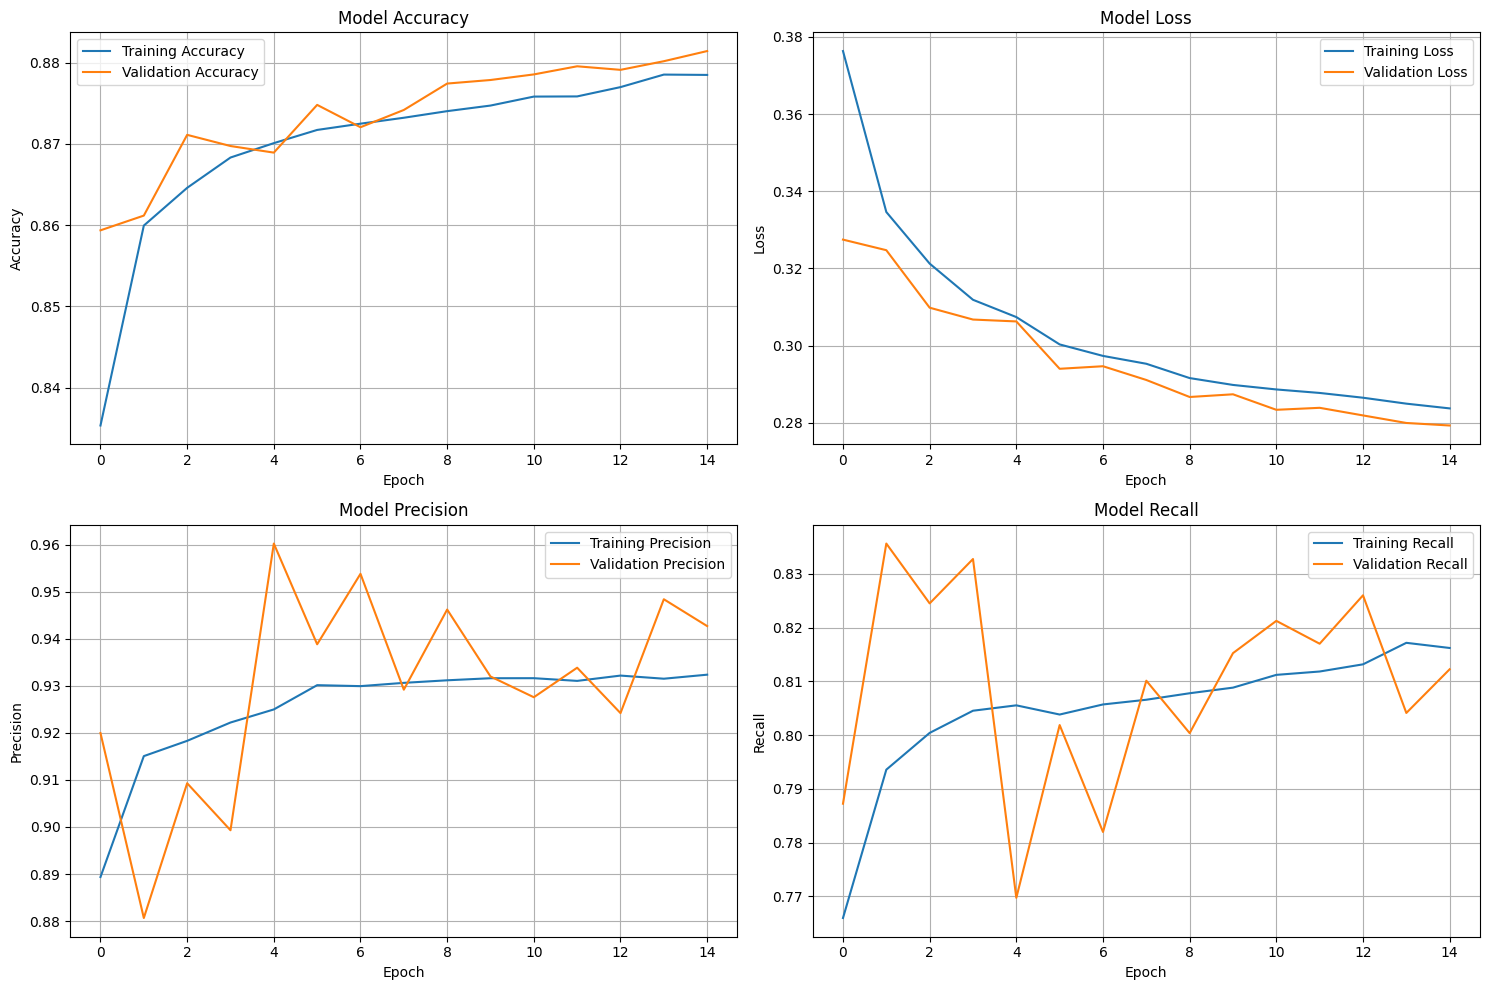

In [ ]:
# ==========================================
# Cell 11: Plot Training History
# ==========================================

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0,0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0,0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0,0].set_title('Model Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True)

# Loss
axes[0,1].plot(history.history['loss'], label='Training Loss')
axes[0,1].plot(history.history['val_loss'], label='Validation Loss')
axes[0,1].set_title('Model Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

# Precision
axes[1,0].plot(history.history['precision'], label='Training Precision')
axes[1,0].plot(history.history['val_precision'], label='Validation Precision')
axes[1,0].set_title('Model Precision')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Precision')
axes[1,0].legend()
axes[1,0].grid(True)

# Recall
axes[1,1].plot(history.history['recall'], label='Training Recall')
axes[1,1].plot(history.history['val_recall'], label='Validation Recall')
axes[1,1].set_title('Model Recall')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Recall')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.savefig(f'{OUTPUTS_DIR}/{MODEL_NAME}_training_history.png', dpi=300, bbox_inches='tight') # 统一命名
plt.show()